In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras
# from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error

In [97]:
df = pd.read_csv('/home/akhil/Downloads/Binance_BTCUSDT_d1.csv', index_col='date')
target_col = 'close'
df = df.iloc[::-1]

In [98]:
def fill_na(df, feature):       # filling null values based on current distribution
    s = df[feature].value_counts(normalize=True)
    missing = df[feature].isnull()
    df.loc[missing,feature] = np.random.choice(s.index, size=len(df[missing]),p=s.values)
fill_na(df, 'tradecount')   # also considering to replace with mean

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1381 entries, 2017-08-17 to 2021-05-27 00:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         1381 non-null   int64  
 1   symbol       1381 non-null   object 
 2   open         1381 non-null   float64
 3   high         1381 non-null   float64
 4   low          1381 non-null   float64
 5   close        1381 non-null   float64
 6   Volume BTC   1381 non-null   float64
 7   Volume USDT  1381 non-null   float64
 8   tradecount   1381 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 107.9+ KB


In [100]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

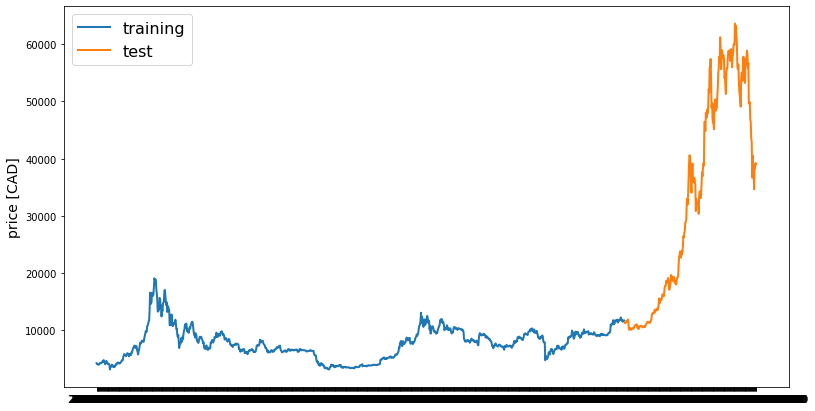

In [101]:
train, test = train_test_split(df, test_size=0.2)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [102]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [103]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [104]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [105]:
np.random.seed(42)
window_len = 3
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
df.drop(['symbol'],axis=1, inplace=True)

In [106]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [21]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/40
35/35 [==============================] - 2s 7ms/step - loss: 0.0032
Epoch 2/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 3/40
35/35 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 4/40
35/35 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 5/40
35/35 [==============================] - 0s 6ms/step - loss: 8.2528e-04
Epoch 6/40
35/35 [==============================] - 0s 7ms/step - loss: 8.8113e-04
Epoch 7/40
35/35 [==============================] - 0s 6ms/step - loss: 7.4595e-04
Epoch 8/40
35/35 [==============================] - 0s 8ms/step - loss: 5.2793e-04
Epoch 9/40
35/35 [==============================] - 0s 6ms/step - loss: 2.5484e-04
Epoch 10/40
35/35 [==============================] - 0s 6ms/step - loss: 9.7479e-04
Epoch 11/40
35/35 [==============================] - 0s 7ms/step - loss: 2.0227e-04
Epoch 12/40
35/35 [==============================] - 0s 6ms/step - loss: 1.6231e-04
Epoch 13/40
35/35

In [22]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.007411413467854226

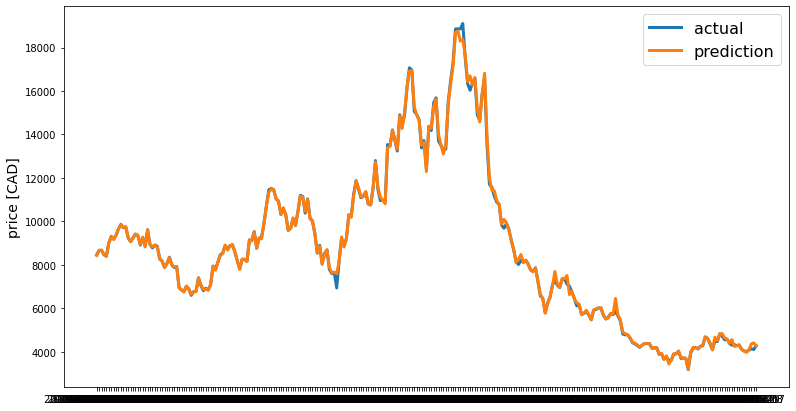

In [23]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [12]:
from pmdarima.arima import auto_arima

In [13]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df.close)

(0.4082010552349422, True)

In [75]:
arima_model=auto_arima(train.close.iloc[:-100], start_p=0, d=1,start_q=0, max_p=5,max_d=5,max_q=5,seasonal_test=True,error_action='warn', trace=True, suppress_warnings=True, stepwise=True, n_jobs=-1)

/home/akhil/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16514.393, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16510.278, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16511.244, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16513.665, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16506.276, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16503.462, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16504.394, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16497.561, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16506.076, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16506.507, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] 

In [76]:
arima_model.fit(train.close.iloc[-100])
predictions = pd.DataFrame(arima_model.predict(n_periods=10))
predictions.columns = ['close']
predictions

TypeError: Singleton array array(6700.) cannot be considered a valid collection.

In [ ]:
plt.plot(test.close.iloc[:10])
plt.plot(predictions)

In [94]:
df

,unix,open,high,low,close,Volume BTC,Volume USDT,tradecount
date,,,,,,,,
2021-05-27 00:00:00,1622073600000,39241.92,39243.10,39072.00,39105.47,328.737300,1.286808e+07,7097.0
2021-05-26 00:00:00,1621987200000,38324.72,40841.00,37800.44,39241.91,104780.773396,4.113718e+09,2432319.0
2021-05-25 00:00:00,1621900800000,38810.99,39791.77,36419.62,38324.72,111996.228404,4.253520e+09,2508310.0
2021-05-24 00:00:00,1621814400000,34681.44,39920.00,34031.00,38796.29,161630.893971,5.996773e+09,3510578.0
2021-05-23 00:00:00,1621728000000,37458.51,38270.64,31111.01,34655.25,217136.046593,7.431242e+09,4082004.0
...,...,...,...,...,...,...,...,...
2017-08-21,1503273600,4086.29,4119.62,3911.79,4016.00,685.120000,2.770592e+06,1707766.0
2017-08-20,1503187200,4139.98,4211.08,4032.62,4086.29,463.540000,1.915636e+06,194567.0
2017-08-19,1503100800,4108.37,4184.69,3850.00,4139.98,371.150000,1.508239e+06,131700.0
